# US Airline Twitter Sentiment Analysis

   Airplane travel is a huge business in the US.  People are always talking about their air travel stories to each other being good or bad.  With twitter people can and will tag the airline in their response to their travel.  

   Since Air travel is a service industry Airlines will want to know how they can improve or what they need to do better from their customers.  From twitter data the airlines can see what features are causing positive or negative tweets.  And from the data decide what to do as a company.

   The data was collected from Twitter in February 2015.  The contributors were asked to first classify positive, negative, or neutral tweets.  The data is on kaggle at https://www.kaggle.com/crowdflower/twitter-airline-sentiment.

## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
df = pd.read_csv('../data/Tweets.csv')

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [5]:
df_1 = df.drop(['airline_sentiment_gold', 'negativereason_gold', 
                'tweet_coord'], axis=1)

Looking we see that some columns have really low non-null object counts.  Columns airline_sentiment_gold has 40, negativereason_gold has 32, and twee_coord only has 1019.  These columns with a lot of missing values won't be of use in the model and will be dropped.  

In [6]:
df_1.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [7]:
df_1 = df_1.drop(['airline_sentiment_confidence', 'negativereason_confidence', 
                  'retweet_count'], axis=1)

Looking at the quantative data we see that the max for retweet_count is 44.  That is too low to be useful for the model.  

The other quantative columns are tweet_id that is an unique key to each tweet.  The two other columns airline_sentiment_confidence and negativereason_confidence seem to be human confidence of rating the tweets.  They will not be helpful and will be dropped.

In [8]:
print(df_1['tweet_id'].unique().shape)
print(df_1['tweet_id'].shape)

(14485,)
(14640,)


In [9]:
df_1.sort_values('tweet_id', inplace=True)
df_1.drop_duplicates(subset='tweet_id', keep=False, inplace=True)

In [10]:
df_1.shape

(14330, 9)

In [11]:
df_1.sort_values('tweet_id', inplace=True)
df_1.drop_duplicates(subset='tweet_id', keep=False, inplace=True)

In [12]:
df_1.shape

(14330, 9)

Looking at the tweet_id column we should see no duplicates but we do.  These duplicates need to be removed.  

## Airline Sentiment

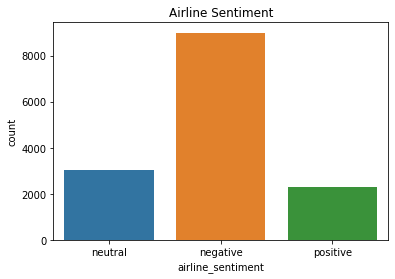

In [13]:
sns.countplot(df_1['airline_sentiment'])
plt.title('Airline Sentiment');

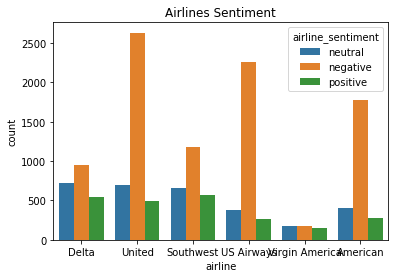

In [14]:
sns.countplot(df_1['airline'], hue=df_1['airline_sentiment'])
plt.title('Airlines Sentiment');

In [15]:
def dummie(df, column):
    df_a = pd.get_dummies(df[column])
    df_a['tweet_id'] = df['tweet_id']
    df = pd.merge(df, df_a, on='tweet_id')
    return df

In [16]:
df_1 = dummie(df_1, 'airline')

In the graph above we see the airline sentiments of each airline neutral, positive, and negative counts.  We see that all but Virgin America have a lot more negative tweets then neutral or positive and in some cases more then both of them combined.

In [17]:
columns = ['negativereason', 'name', 'tweet_created', 
           'tweet_location', 'user_timezone']

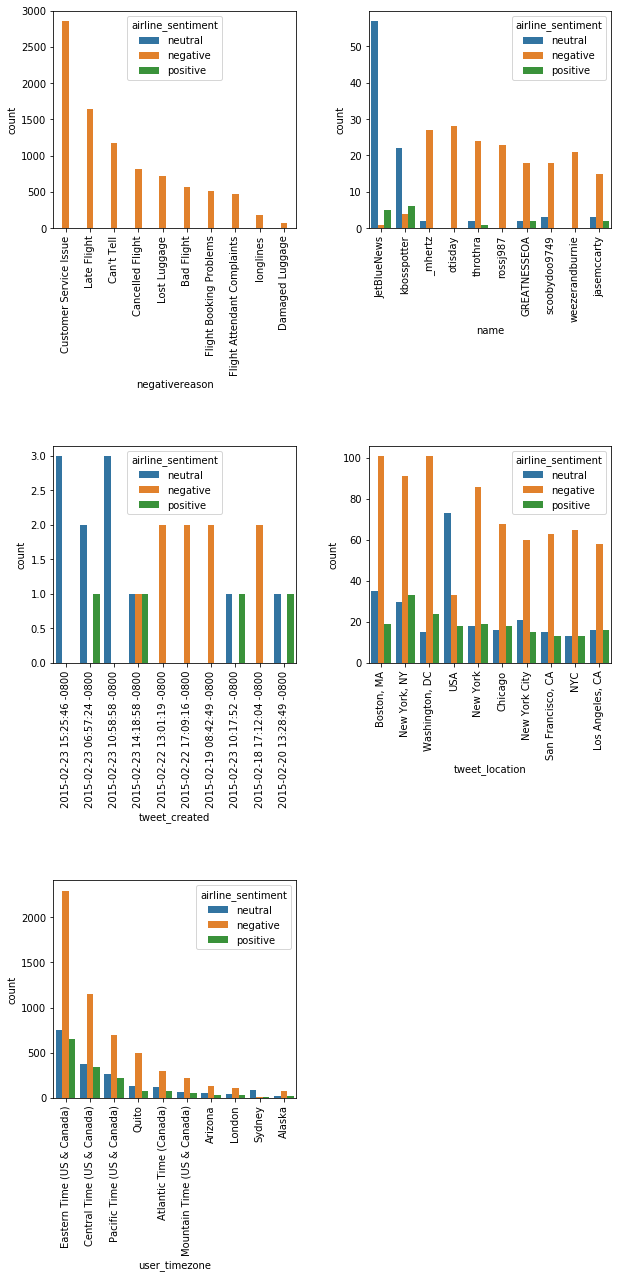

In [18]:
fig = plt.figure(figsize=(10, 20))
fig.subplots_adjust(hspace=1, wspace=0.3)

for i, c in enumerate(columns, start=1):
    ax = fig.add_subplot(3, 2, i)
    chart = sns.countplot(x=c, data=df_1, hue='airline_sentiment',
                          order=df_1[c].value_counts().iloc[:10].index)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [19]:
df_1 = df_1.drop(['negativereason', 'name'], axis=1)

The graphs above show us the top ten most frequent values in the categorical columns.  We see that columns name, tweet_created, tweet_location have very low counts.  But looking at tweet_created as a different type of date would probably bring the counts up.  We could do day of week, hour, or month date.

## Time of Tweet

In [20]:
df_1['day'] = pd.DatetimeIndex(df_1['tweet_created']).dayofweek
df_1['hour'] = pd.DatetimeIndex(df_1['tweet_created']).hour
df_1['date'] = pd.DatetimeIndex(df_1['tweet_created']).date

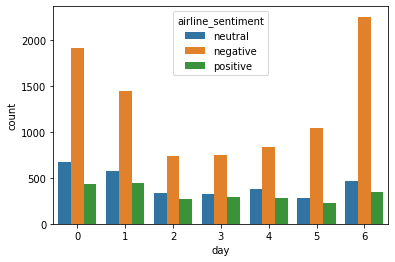

In [21]:
chart = sns.countplot(x='day', data=df_1, hue='airline_sentiment');

In [22]:
df_1 = dummie(df_1, 'day')

In [23]:
df_1 = df_1.rename(columns={0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
                            3: 'Thursday', 4: 'Friday', 5: 'Saturday', 
                            6: 'Sunday'})

We see that most tweets were created on Monday, Tuesday, and Sunday.  This is probably when people are coming home from their vactions.

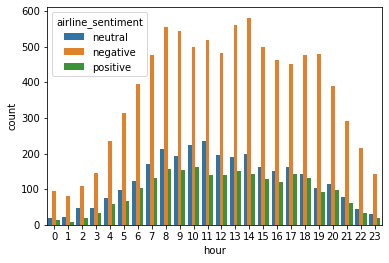

In [24]:
chart = sns.countplot(x='hour', data=df_1, hue='airline_sentiment');

Tweets by hour of the day have a normalized pattern.

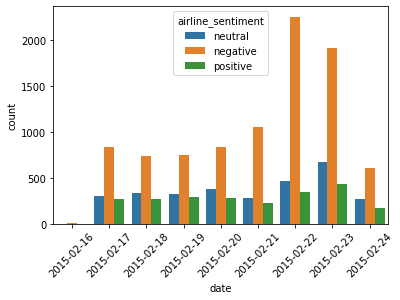

In [25]:
chart = sns.countplot(x='date', data=df_1, hue='airline_sentiment')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

We see that data was only collected over 8 days Between February 16 and 24 in 2015.

## Timezone

In [26]:
print('Rows where user_timezone is null but tweet_location has value: ', 
      df_1['tweet_location'][df_1['user_timezone'].isnull()].count())

Rows where user_timezone is null but tweet_location has value:  2113


In [27]:
df_1['tweet_location'][df_1['user_timezone'].isnull()].value_counts().head(10)

New York                 47
San Francisco, CA        29
Boston, MA               26
USA                      25
Chicago, IL              24
Chicago                  23
San Diego                22
McKinney TX              22
Belle MO                 21
Does it really matter    19
Name: tweet_location, dtype: int64

In [28]:
us_time = {'Alaska': ['AK', 'ALASKA'], 
           'Central Time (US & Canada)': ['AL', 'AR', 'IL', 'IA', 
                                          'KS', 'KY', 'LA', 'MN', 
                                          'MI', 'MO', 'NE', 'ND', 
                                          'OK', 'SD', 'TN', 'TX', 
                                          'WI', 'ALABAMA', 
                                          'ARKANSAS','ILLINOIS', 
                                          'IOWA', 'KANSAS', 
                                          'KENTUCKY', 'LOUISIANA', 
                                          'MINNESOTA', 'MISSISSIPPI',
                                          'MISSOURI', 'NEBRASKA', 
                                          'NORTH DAKOTA','OKLAHOMA',
                                          'SOUTH DAKOTA','TENNESSEE',
                                          'TEXAS', 'WISCONSIN'], 
           'Eastern Time (US & Canada)': ['CT', 'DE', 'DC', 'FL', 
                                          'GA', 'IN', 'ME', 'MD', 
                                          'MA', 'MI', 'NH', 'NJ', 
                                          'NY', 'NC', 'OH', 'PA', 
                                          'RI', 'SC', 'VT', 'VA', 
                                          'WV', 'CONNECTICUT', 
                                          'DELAWARE', 'FLORIDA', 
                                          'GEORGIA', 'INDIANA', 
                                          'MAINE', 'MARYLAND', 
                                          'MASSACHUSETTS', 
                                          'MICHIGAN','NEW HAMPSHIRE', 
                                          'NEW JERSEY', 'NEW YORK', 
                                          'NORTH CAROLINA', 'OHIO', 
                                          'PENNSYLVANIA', 
                                          'RHODE ISLAND', 
                                          'SOUTH CAROLINA', 
                                          'VERMONT', 'VIRGINIA', 
                                          'WEST VIRGINIA'], 
           'Mountain Time (US & Canada)': ['AZ', 'CO', 'ID', 'MT', 
                                           'NM', 'UT', 'WY', 
                                           'ARIZONA', 'COLORADO', 
                                           'IDAHO', 'MONTANA', 
                                           'NEW MEXICO', 'UTAH', 
                                           'WYOMING'], 
           'Pacific Time (US & Canada)' : ['CA', 'NV', 'OR', 'WA', 
                                           'CALIFORNIA', 'NEVADA', 
                                           'OREGON', 'WASHINGTON']
          }

In [29]:
def try_extract(s, p):
    try:
        s.upper()
        return p.search(s).group(1)
    except (TypeError, AttributeError):
        return s

In [30]:
for k in us_time.keys():
    l = us_time[k]

    p = re.compile(rf"({'|'.join(l)})")
    df_1['test_1'] = [try_extract(s, p) for s in df_1['tweet_location']]
    
df_1['user_timezone'] = df_1['user_timezone'].fillna(df_1['test_1'])
df_1 = df_1.drop(['test_1'], axis=1);

Looking at user_timezone and tweet_location we see that they both contain locations.  

We see that there are 2149 rows where the user_timezone is null but the tweet_location has a value.  Looking at the values we see that a lot of them contain a state.  We will be able to assign a value to the user_timezone null value according to the state in the tweet_location.

In [31]:
df_1['user_timezone'].value_counts().head(10)

Eastern Time (US & Canada)     3696
Central Time (US & Canada)     1869
Pacific Time (US & Canada)     1184
Quito                           710
Atlantic Time (Canada)          491
Mountain Time (US & Canada)     347
Arizona                         223
London                          198
CA                              112
Sydney                          107
Name: user_timezone, dtype: int64

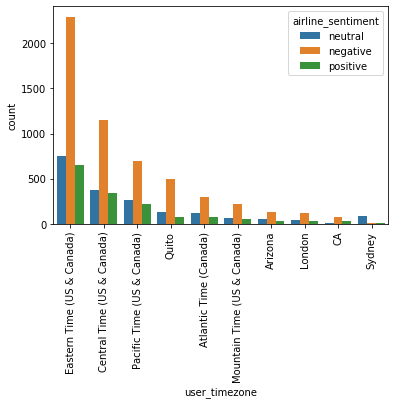

In [32]:
chart = sns.countplot(x ='user_timezone', hue='airline_sentiment', 
                      data=df_1, 
                      order=df_1['user_timezone'].value_counts().iloc[:10].index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

Looking at the top ten user_timezones we see that all of them have more negative sentiments then other sentiments with some by a lot.

In [33]:
ut_tail = df_1['user_timezone'].value_counts().shape[0] - 10
# Create list of the non top ten inthe user_timezone 
user_timezone_lowest = list(df_1['user_timezone'].value_counts().tail(ut_tail).index)
# create a dummie matrix of user_timezone
df_1 = dummie(df_1, 'user_timezone')

In [34]:
# create other_timezone column and fill with zero
df_1['other_timezone'] = 0
# combine non top ten user_timezone into other_timezone column
for c in user_timezone_lowest:
    df_1['other_timezone'] = df_1['other_timezone'] + df_1[c]
    df_1 = df_1.drop(c, axis=1)

In [35]:
df_1 = df_1.drop('tweet_location', axis=1)

We will drop tweet_location because there aren't a lot of samples.

In [36]:
df_1['tweet_char_len'] = df_1['text'].str.len()

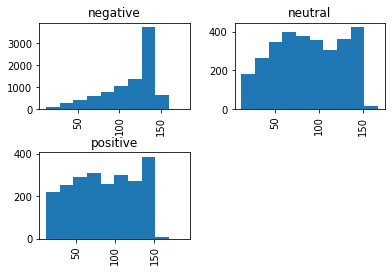

In [37]:
df_1.hist(column='tweet_char_len', by='airline_sentiment');

We can create a value with the tweet text charactor length and see if there is corrilation betwee tweet length and negative or positive sentiment.

Looking at the negative and other sentiment histograms we see that negative twee_char_len is skewed toards the right 

In [38]:
df_1 = df_1.drop(['airline', 'user_timezone', 'day', 'hour', 'date', 
                  'tweet_created'], axis=1)

## Clean Text

In [39]:
import nltk
from nltk.corpus import stopwords

In [40]:
def process_tweets(tweet):
    # convert text to lower-case
    tweet = tweet.lower()
    # remove URLs
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 
                   '', tweet)
    # remove usernames
    tweet = re.sub('@[^\s]+', '', tweet)
    # remove the # in #hashtag
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) 
    # remove punctuation
    tweet = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', 
                   tweet)
    # remove stopwords
    tweet = ' '.join(word for word in tweet.split() 
                     if word not in stopwords.words('english')) 
            
    return tweet

In [41]:
df_1['tweet_clean'] = df_1['text'].apply(process_tweets)

## Word Clouds

In [42]:
from wordcloud import WordCloud

In [43]:
def wordcloud_graph(sentiment='negative'):
    text = " ".join(tweet for tweet in df_1['tweet_clean'][df_1['airline_sentiment'] == sentiment])
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords.words('english'), 
                          background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

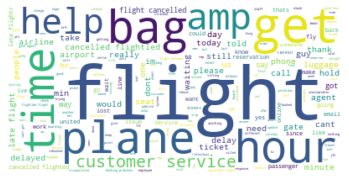

In [44]:
wordcloud_graph('negative')

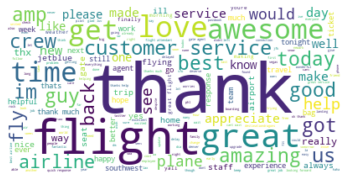

In [45]:
wordcloud_graph('positive')

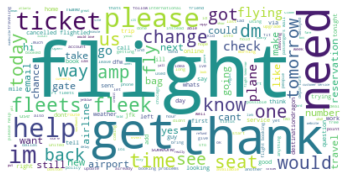

In [46]:
wordcloud_graph('neutral')

## Model Selection

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_1['tweet_clean'], 
                                                    df_1['airline_sentiment'], 
                                                    test_size=0.33, 
                                                    shuffle=True, 
                                                    random_state = 42)

### Models

In [49]:
from sklearn.model_selection import KFold

# use it because it is fast with count vectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from scipy import stats

from sklearn.pipeline import Pipeline
import pickle

In [50]:
# have the model be split into 3 folds
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# set f1 variable as constant
f1='f1_macro'

In [51]:
# create multinomialNB clf and hyperparameters
clf_mnb = MultinomialNB()
mnb_hyperparameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                       'clf__alpha': [0.001, 0.01, 0.1, 10, 20, 30, 40, 
                                      50, 60, 70, 80, 90, 100]}

# create SVC clf and hyperparameters
clf_svc = SVC()
svc_hyperparameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                       'clf__C': stats.expon(scale=100), 
                       'clf__gamma': stats.expon(scale=.1), 
                       'clf__kernel': ['rbf'], 
                       'clf__class_weight': ['balanced', None]}

# create RandomForestClassifier clf and hyperparameters
clf_rfc = RandomForestClassifier()
rfc_hyperparameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                       'clf__n_estimators': stats.randint(10,300), 
                       'clf__criterion': ['gini', 'entropy'], 
                       'clf__min_samples_split': stats.randint(2,9), 
                       'clf__bootstrap': [True, False],
                       'clf__class_weight': [None, 'balanced', 
                                             'balanced_subsample']
                      }

# Create Vectorizers
cv = CountVectorizer()
tf = TfidfVectorizer()

### Cross Validation

In [52]:
# function that gets the best scores from the training and validatin sets of 
# Cross Validation
def clf_scores(clf):
    training_score = clf.cv_results_['mean_train_score'][clf.best_index_]
    training_std = clf.cv_results_['std_train_score'][clf.best_index_]

    validation_score = clf.best_score_
    test_std = clf.cv_results_['std_test_score'][clf.best_index_]
    
    train = str(round(training_score, 3)) + ' (' + str(round(training_std, 3)) + ')' 
    val = str(round(validation_score, 3)) + ' (' + str(round(test_std, 3)) + ')'

    score_list = {'train-score': train, 
                  'validation-score': val}
    
    return score_list

In [53]:
# Save the model
def clf_save(clf, filename):
    file = '../models/' + filename + '.sav'
    pickle.dump(clf, open(file, 'wb'))

In [54]:
# Runs grid search on pipeline and data set given
# returns scores in dictionary
def train_and_score_model_gridcv(name, X_train, y_train, pipeline, model_info, 
                                 kfold, score='f1_macro'):
    t0 = time.time()

    searchCV = GridSearchCV(estimator=pipeline, 
                            param_grid=model_info, 
                            cv=kfold,
                            scoring=score,
                            n_jobs=-1, 
                            return_train_score=True)

    searchCV.fit(X_train, y_train)
    
    score = clf_scores(searchCV)
    
    clf_save(searchCV, name)
    
    t1 = time.time()
    timeit = round((t1-t0), 2)
    
    print(name, str(timeit) + ' sec')
    
    return score  

In [55]:
# Runs random search on pipeline and data set given
# returns scores in dictionary
def train_and_score_model_rscv(name, X_train, y_train, pipeline, model_info, 
                               kfold, niter=1000, score='f1_macro'):
    t0 = time.time()
    
    searchCV = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=model_info, 
                                  cv=kfold,
                                  n_iter=niter,
                                  scoring=score,
                                  random_state=42, 
                                  n_jobs=-1, 
                                  return_train_score=True)
    
    searchCV.fit(X_train, y_train)
    
    score = clf_scores(searchCV)
    
    clf_save(searchCV, name)
    
    t1 = time.time()
    timeit = round((t1-t0) / 60 / 60, 3)
    
    print(name, str(timeit) + ' hrs')

    return score

In [56]:
# Create dicts with vectors
vector_list = {'CountVectorizer': cv,
               'TfidfVectorizer': tf}

# Create dict with models and parameters
models_list = {'MultinomialNB': (clf_mnb, mnb_hyperparameters),
               'SVC': (clf_svc, svc_hyperparameters),
               'RandomForestClassifer': (clf_rfc, rfc_hyperparameters)}

# Dict to store model scores
model_cvs = {}

In [57]:
# Cycle through every Vectorizer
for vector_name, vector_info in vector_list.items():
    # Cycle through models for cross validation
    for model_name, model_info in models_list.items():
        # create pipeline with vector, scaler and clf
        clf_pipeline = Pipeline([('vect', vector_info),
                                 ('scaler', MaxAbsScaler()), 
                                 ('clf', model_info[0])])
        # create string with vector, and model name
        name = vector_name + model_name
        # if model is MultinomialNB use gridsearchcv
        if model_name == 'MultinomialNB':
            model_cvs[name] = train_and_score_model_gridcv(name,
                                                           X_train, 
                                                           y_train,  
                                                           clf_pipeline, 
                                                           model_info[1], 
                                                           kfold, 
                                                           f1)
        else: # else use randomsearchcv
            model_cvs[name] = train_and_score_model_rscv(name,
                                                         X_train, 
                                                         y_train, 
                                                         clf_pipeline, 
                                                         model_info[1], 
                                                         kfold, 
                                                         1000, 
                                                         f1)

In [95]:
# create df from model_cvs scores dict
df_scores = pd.DataFrame.from_dict(model_cvs).transpose()
df_scores

,train-score,validation_score,time
CountVectorizerMultinomialNB,0.969 (0.002),0.634 (0.009),0.00504961
CountVectorizerSVC,0.968 (0.001),0.707 (0.01),4.37049
CountVectorizerRandomForestClassifer,0.989 (0.0),0.701 (0.015),6.68523
TfidfVectorizerMultinomialNB,0.985 (0.001),0.639 (0.009),0.00424452
TfidfVectorizerSVC,0.88 (0.001),0.695 (0.005),4.64268
TfidfVectorizerRandomForestClassifer,0.99 (0.0),0.698 (0.008),6.36558


## Model Test

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [104]:
# Create dict that holds metrics
metric_dict = {}
metric_dict['accuracy'] = []
metric_dict['precision'] = []
metric_dict['recall'] = []
metric_dict['f1'] = []

file_names = pd.DataFrame.from_dict(model_cvs).transpose().index

# Cycle through models predicting on test data and giving metrics
for f in file_names:
    # load models
    file = '../models/' + f + '.sav'
    loaded_model = pickle.load(open(file, 'rb'))
    # predict test set
    prediction = loaded_model.predict(X_test)
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = round(accuracy_score(y_test, prediction), 3)
    metric_dict['accuracy'].append(accuracy)
    # precision tp / (tp + fp)
    precision = round(precision_score(y_test, prediction, average='macro'), 3)
    metric_dict['precision'].append(precision)
    # recall: tp / (tp + fn)
    recall = round(recall_score(y_test, prediction, average='macro'), 3)
    metric_dict['recall'].append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = round(f1_score(y_test, prediction, average='macro'), 3)
    metric_dict['f1'].append(f1)

In [105]:
# add metrics to df_scores
for k in metric_dict.keys():
    df_scores[k] = metric_dict[k]
    
df_scores

,train-score,validation_score,time,accuracy,precision,recall,f1
CountVectorizerMultinomialNB,0.969 (0.002),0.634 (0.009),0.00504961,0.739,0.688,0.617,0.641
CountVectorizerSVC,0.968 (0.001),0.707 (0.01),4.37049,0.774,0.731,0.699,0.713
CountVectorizerRandomForestClassifer,0.989 (0.0),0.701 (0.015),6.68523,0.758,0.708,0.693,0.700
TfidfVectorizerMultinomialNB,0.985 (0.001),0.639 (0.009),0.00424452,0.735,0.669,0.624,0.640
TfidfVectorizerSVC,0.88 (0.001),0.695 (0.005),4.64268,0.749,0.696,0.713,0.703
TfidfVectorizerRandomForestClassifer,0.99 (0.0),0.698 (0.008),6.36558,0.760,0.703,0.693,0.698
